<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Analysis-Migration-Discourse-as-Social-Networks" data-toc-modified-id="Analysis-Migration-Discourse-as-Social-Networks-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Analysis Migration Discourse as Social Networks</a></span></li><li><span><a href="#Marijn's-analysis" data-toc-modified-id="Marijn's-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Marijn's analysis</a></span></li><li><span><a href="#My-analysis" data-toc-modified-id="My-analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>My analysis</a></span></li></ul></div>

## Analysis Migration Discourse as Social Networks

Method:
- generate networks per period, each person or organisation is a node
    - **Shape**: different types of nodes have different shapes: organisation, academic, technocrat
    - **Color**: use different colours to represent different nationalities, grey for unknown nationalities, black for organisations
    

Vragen:

- Beijer, G. Beijer en G.O.K. Beijer zijn dezelfde persoon?
- sommige contributors van de studies staan niet in de personenlijst. Hoe categoriseren we die?



In [1]:
import pandas as pd
import networkx as nx

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from scripts.network_analysis import retrieve_spreadsheet_records

def lowercase_headers(records:list):
    return [dict((k.lower(), v) for k,v in record.items()) for record in records] 

entity_records = retrieve_spreadsheet_records(record_type='entities')
entity_records = lowercase_headers(entity_records)
print('Number of records:' , len(entity_records))


Number of records: 74


In [4]:
import json

for record in entity_records:
    print(json.dumps(record, indent=4))

{
    "organisation": "REMP",
    "period_start": "1952",
    "last_known_date": "1983",
    "prs_id": "1",
    "prs_surname": "Beijer",
    "prs_infix": "",
    "prs_initials": "G.",
    "prs_function": "demographer, The Hague",
    "prs_category": "academic",
    "is_academic": "yes",
    "is_public_administration": "",
    "prs_country": "NL",
    "prs_role1": "founder",
    "prs_role2": "member_MC",
    "prs_role3": "secretary-editor",
    "remarks": "director-editor (1969)"
}
{
    "organisation": "REMP",
    "period_start": "1952",
    "last_known_date": "1969",
    "prs_id": "2",
    "prs_surname": "Groenman",
    "prs_infix": "",
    "prs_initials": "Sj.",
    "prs_function": "sociologist, Leiden",
    "prs_category": "academic",
    "is_academic": "1947",
    "is_public_administration": "1943-1950",
    "prs_country": "NL",
    "prs_role1": "founder",
    "prs_role2": "member_MC",
    "prs_role3": "vice-chair_BoD",
    "remarks": ""
}
{
    "organisation": "REMP",
    "period_

In [5]:
# index each person entity with their category (academic, technocrat)
def get_entity_name(entity: dict, ):
    name_labels = ['prs_surname', 'prs_infix', 'prs_initials']
    if entity['prs_infix'] != '':
        return f"{entity['prs_surname']}, {entity['prs_infix']}, {entity['prs_initials']}"
    else:
        return f"{entity['prs_surname']}, {entity['prs_initials']}"

entity_roles = {get_entity_name(record): [record['prs_role1'], record['prs_role2'], record['prs_role3']] for record in entity_records}
for k in entity_roles:
    nr = [e for e in entity_roles[k] if e !='']
    entity_roles[k]=nr
entity_roles

{'Beijer, G.': ['founder', 'member_MC', 'secretary-editor'],
 'Groenman, Sj.': ['founder', 'member_MC', 'vice-chair_BoD'],
 'Zeegers, G.H.L.': ['founder', 'member_MC', 'member_BoD'],
 'Hofstee, E.W.': ['founder', 'member_BoD'],
 'Bouman, P.J.': ['member_BoD', 'chair_BoD (1954)'],
 'Oldendorff, A.': ['member_BoD'],
 'Gelissen, H.': ['member_BoD'],
 'Schokking, J.J.': ['member_BoD'],
 'Sauvy, A.': ['chair_BoD', 'chair_MC'],
 'Gottmann, J.': ['member_BoD'],
 'Lacroix, M.': ['member_BoD'],
 'Jacobson, P.': [],
 'Winkler, W.': ['member_BoD'],
 'Janne, H.': ['member_BoD'],
 'Mertens de Wilmars, J.': ['member_BoD', 'member_MC'],
 'Baade, F.': ['member_BoD'],
 'Mackenroth, G.': ['member_BoD', 'member_MC'],
 'Ritschl, H.': ['member_BoD'],
 'Hoffmann, W.': ['member_BoD'],
 'Neundorffer, L.': ['member_BoD'],
 'Gadolin, de, A.': ['member_BoD'],
 'Vito, F.': ['member_BoD'],
 'Livi, L.': ['member_BoD'],
 'Parenti, G.': ['member_BoD'],
 'Vergottini, M.': ['member_BoD'],
 'Vampa, D': ['member_BoD', 'm

In [6]:
from scripts.network_analysis import retrieve_spreadsheet_records

relationship_records = retrieve_spreadsheet_records(record_type='relationships')
len(relationship_records)

143

In [7]:
pd.DataFrame().from_records(relationship_records).columns

Index(['series', 'volume', 'year', 'article_author1_surname',
       'article_author1_infix', 'article_author1_initials',
       'article_author2_surname', 'article_author2_infix',
       'article_author2_initials', 'preface_author1_surname',
       'preface_author1_infix', 'preface_author1_initials',
       'preface_author2_surname', 'preface_author2_infix',
       'preface_author2_initials', 'intro_author1_surname',
       'intro_author1_infix', 'intro_author1_initials',
       'intro_author2_surname', 'intro_author2_infix',
       'intro_author2_initials', 'executor_org', 'funder', 'client',
       'editor_surname', 'editor_infix', 'editor_initials', 'volume_title'],
      dtype='object')

In [8]:
from itertools import chain


In [9]:
er = list(set(chain.from_iterable(entity_roles.values())))
er

['Correspondent',
 'member_BoD',
 'vice-chair_BoD',
 'chair_BoD (1954)',
 'chair_BoD',
 'member_MC',
 'chair_MC',
 'founder',
 'member _MC',
 'secretary-editor']

In [10]:
{'vice-chair_BoD':'REMP director',
 'Dep_dir_ICEM':'ICEM',
 'chair_MC':'REMP board',
 'AB':"REMP board",
 'Correspondent':"correspondent",
 'member _MC':"REMP board",
 'chair_BoD':"REMP director",
 'member_BoD':"REMP director",
 'founder':"founder",
 'editor':"editor",
 'member_MC':"REMP board"}

roled = {'author':['article_author1_surname','article_author2_surname'],
 'preface_author':['preface_author1_surname','preface_author2_surname'],
 'intro_author':['intro_author1_surname','intro_author2_surname'],
 'executor':['executor_org'], 
 'funder':['funder'],
 'client':['client'],
 'editor':['editor_surname'],
 'unknown':['']}

rroled = {w:k for k,v in roled.items() for w in v}
rroled
# roles = ['executor', 'funder', 'board', 'client',
#        'editor', 'author', 'preface_writer', 'intro_writer']

{'article_author1_surname': 'author',
 'article_author2_surname': 'author',
 'preface_author1_surname': 'preface_author',
 'preface_author2_surname': 'preface_author',
 'intro_author1_surname': 'intro_author',
 'intro_author2_surname': 'intro_author',
 'executor_org': 'executor',
 'funder': 'funder',
 'client': 'client',
 'editor_surname': 'editor',
 '': 'unknown'}

In [56]:
categorized_persons = retrieve_spreadsheet_records("categories")
categorized_persons = lowercase_headers(categorized_persons)

In [57]:
from collections import defaultdict, Counter

from scripts.network_analysis import extract_record_entities


def get_entity_category(entity: dict):
    if entity['entity_name'] in entity_category:
        return entity_category[entity['entity_name']] 
    else:
        return 'unknown'

In [58]:
from collections import defaultdict, Counter
record_entities = defaultdict(list)
entity_count = Counter()
entity_role_count = Counter()
for ri, record in enumerate(relationship_records):
    entities = extract_record_entities(record)
    record_entities[ri].append(entities)
    entity_count.update([entity['entity_name'] for entity in entities if 'entity_name' in entity])
    entity_role_count.update([entity['entity_role'] + ' ' + entity['entity_name'] for entity in entities if 'entity_name' in entity])
    for entity in entities:
        if entity['entity_type'] == 'person':
            entity['entity_type'] = get_entity_category(entity)
        print(entity)
    print(ri)
    
    

{'entity_name': 'RCE', 'entity_role': 'executor_org', 'entity_type': 'organisation'}
{'entity_name': 'ICEM', 'entity_role': 'funder', 'entity_type': 'organisation'}
{'entity_name': 'RCE', 'entity_role': 'client', 'entity_type': 'organisation'}


NameError: name 'entity_category' is not defined

In [16]:
record_entities

defaultdict(list,
            {0: [[{'entity_name': 'RCE',
                'entity_role': 'executor_org',
                'entity_type': 'organisation'},
               {'entity_name': 'ICEM',
                'entity_role': 'funder',
                'entity_type': 'organisation'},
               {'entity_name': 'RCE',
                'entity_role': 'client',
                'entity_type': 'organisation'},
               {'entity_name': 'Hofstede, B.P.',
                'entity_role': 'article_author',
                'entity_type': 'person'},
               {'entity_name': 'Groenman, Sj.',
                'entity_role': 'preface_author',
                'entity_type': 'person'},
               {'entity_type': 'publication',
                'series': 'Studies over Nederlandse emigratie',
                'volume': '1',
                'year': 1958,
                'volume_title': 'De gaande man : gronden van de emigratiebeslissing : rapport naar aanleiding van een onderzoek / verricht in

In [55]:
def make_nodes(entity):
    return [n.get('entity_name') for n in entity if n.get('entity_name')]
    
def make_link_from_entity(entity, revnodelist):
    counter = []
    authors = [n.get('entity_name') for n in entity if n.get('entity_role')=='article_author']
    links = []
    for aut in authors:
        autnr = revnodelist[aut]
        counter.append(autnr)
        for node in entity:
            if node.get('entity_role') != 'article_author':
                if node.get('entity_role'): # we don't include titles
                    category = node.get('entity_role') or "unknown"
                    target = revnodelist[node.get('entity_name')]
                    graphnode = rempgraph.nodes()[target]
                    if graphnode.get('category'):
                        graphnode['category'].append(category)
                    else:
                        graphnode['category']= [category]
                    link = (autnr, target, {"link_type": node.get('entity_role') or 'unknown'})
                    links.append(link)
                    counter.append(target)
    
    return links, counter

In [53]:
nodelist = []
for rentity in record_entities:
    nodelist.extend(make_nodes(record_entities[rentity][0]))
nodelist = list(set(nodelist))
revnodelist = {}
rempgraph = nx.Graph()
for node in enumerate(nodelist):
    rempgraph.add_node(node[0], id=node[0], name=node[1])
    revnodelist[node[1]]=node[0]

In [54]:
rempgraph.nodes

NodeView((0, 1, 2, 3))

In [20]:
linklist = []
counter = Counter()
for rentity in record_entities:
    links, cntr = make_link_from_entity(record_entities[rentity][0], revnodelist)
    linklist.extend(links)
    counter.update(cntr)

In [21]:
counter.most_common(10)

[(0, 2), (2, 1), (3, 1), (1, 1)]

In [22]:
for node in rempgraph.nodes():
    n = rempgraph.nodes()[node]
    value = counter[n['id']]
    n['value'] = value
    

In [23]:
import networkx as nx
rempgraph.add_edges_from(linklist)
nx.draw(rempgraph, pos=nx.spring_layout(rempgraph, weight=value))

## Marijn's analysis

In [24]:
for entity, count in entity_count.most_common():
    print(f'{entity: <30}{count: >3}')

RCE                             2
ICEM                            1
Hofstede, B.P.                  1
Groenman, Sj.                   1


In [25]:
for entity, count in entity_role_count.most_common():
    print(f'{entity: <30}{count: >3}')

executor_org RCE                1
funder ICEM                     1
client RCE                      1
article_author Hofstede, B.P.   1
preface_author Groenman, Sj.    1


In [26]:
from scripts.network_analysis import make_bibliographic_records

bib_records = make_bibliographic_records(relationship_records)
print(bib_records[0])
len(bib_records)


{'article_title': 'De gaande man : gronden van de emigratiebeslissing : rapport naar aanleiding van een onderzoek / verricht in opdracht van de Regeringscommissaris voor de Emigratie', 'article_doi': None, 'article_author': 'Hofstede, B.P.', 'article_author_index_name': 'Hofstede, B.P.', 'article_author_affiliation': '', 'article_page_range': None, 'article_pub_date': '1958', 'article_pub_year': 1958, 'issue_section': 'article', 'issue_number': None, 'issue_title': None, 'issue_page_range': None, 'issue_pub_date': '1958', 'issue_pub_year': 1958, 'volume': '1', 'journal': 'Studies over Nederlandse emigratie', 'publisher': 'REMP'}


169

In [49]:
headers = [
    'article_title', 'article_doi', 
    'article_author', 'article_author_index_name', 'article_author_affiliation', 
    'article_page_range', 'article_pub_date', 'article_pub_year', 
    'issue_section', 'journal', 'volume', 'issue', 
    'issue_title', 'issue_page_range', 'issue_pub_date', 'issue_pub_year', 
    'publisher'
]

remp_records_file = '../data/remp-records.json'
with open(remp_records_file, 'wt') as fh:
    json.dump(bib_records, fh)

In [101]:
from scripts.network_analysis import generate_graph, add_entities, add_record_links

graph = generate_graph()

periods = [
    {'start': 1950, 'end': 1959}, 
    {'start': 1960, 'end': 1969},
    {'start': 1970, 'end': 1979},
    {'start': 1980, 'end': 1989},
]

period = periods[0]
for record in relationship_records:
    record['year'] = int(record['year'])
for ri, record in enumerate(sorted(relationship_records, key = lambda x: x['year'])):
    record['year'] = int(record['year'])
    if record['year'] < period['start'] or record['year'] > period['end']:
        continue
    print(record['year'])
    entities = extract_record_entities(record)
    for entity in entities:
        if entity['entity_type'] == 'person':
            entity['entity_type'] = get_entity_category(entity)
    named_entities = [entity for entity in entities if 'entity_name' in entity]
    print([entity['entity_name'] for entity in named_entities])
    add_entities(graph, named_entities)
    add_record_links(graph, named_entities)
    if ri == 100:
        break

graph.number_of_nodes()

1951


NameError: name 'entity_category' is not defined

In [78]:
graph.nodes()

NodeView(())

In [79]:
len(graph.edges())

0

In [80]:
graph.edges()

EdgeView([])

## My analysis

In [81]:
import matplotlib.pyplot as plt

import networkx as nx

In [82]:
cp_df.head()

,organisation,period_start,last_known_date,prs_id,prs_surname,prs_infix,prs_initials,prs_function,prs_category,is_academic,is_public_administration,prs_country,prs_role1,prs_role2,prs_role3,remarks,norm_name,orgcat
0,REMP,1952,1983,1,Beijer,,G.,"demographer, The Hague",academic,yes,,NL,founder,member_MC,secretary-editor,director-editor (1969),"Beijer, G.",3
1,REMP,1952,1969,2,Groenman,,Sj.,"sociologist, Leiden",academic,1947,1943-1950,NL,founder,member_MC,vice-chair_BoD,,"Groenman, Sj.",3
2,REMP,1952,1969,3,Zeegers,,G.H.L.,"economist, sociologist, Nijmegen",academic,yes,1941-1950,NL,founder,member_MC,member_BoD,,"Zeegers, G.H.L.",3
3,REMP,1952,1969,4,Hofstee,,E.W.,"sociologist, Wageningen",academic,yes,"yes, advisor 5 ministeries",NL,founder,member_BoD,,,"Hofstee, E.W.",3
4,REMP,1952,1969,5,Bouman,,P.J.,"sociologist, Groningen",academic,yes,,NL,member_BoD,,chair_BoD (1954),,"Bouman, P.J.",3


In [83]:

import pandas as pd 

def categorize_node(n):
    cat = 0
    if n.get("is_academic")!= '':
        cat += 1
    if n.get("is_public_admistration") != '':
        cat += 2
    return cat


cp_df = pd.DataFrame().from_records(categorized_persons)
cp_df['norm_name'] = cp_df.apply(lambda x: get_entity_name(x), axis=1)
cp_df['orgcat'] = cp_df.apply(lambda x: categorize_node(x), axis=1)



In [84]:

for n in rempgraph.nodes():
    r = cp_df.loc[cp_df.norm_name == rempgraph.nodes()[n]['name']]
    if len(r) > 0:
        rec = r[['organisation', 'period_start', 'last_known_date', 'norm_name', 'prs_country', 'orgcat']].to_dict('records')[0]
        rempgraph.nodes[n].update(rec)
        
#         print(rempgraph.nodes()[n]['name'], r)

In [85]:
for n in rempgraph.nodes():
    node = rempgraph.nodes()[n]
    if node.get('category'):
        node['category']= list(set(node['group']))
    else:
        node['category'] = ['unknown']
    node['category'] = ''.join([c[0] for c in node['category']])

In [86]:
json_graph2 = json_graph.node_link_data(rempgraph, attrs=dict(source='source', target='target',
                                                         name='id', nid='id', links='links'))
json_graph2

{'directed': False,
 'multigraph': False,
 'graph': {},
 'nodes': [{'id': 0, 'name': 'RCE', 'category': 'u'},
  {'id': 1,
   'name': 'Groenman, Sj.',
   'organisation': 'REMP',
   'period_start': '1952',
   'last_known_date': '1969',
   'norm_name': 'Groenman, Sj.',
   'prs_country': 'NL',
   'orgcat': 3,
   'category': 'u'},
  {'id': 2,
   'name': 'Hofstede, B.P.',
   'organisation': 'Dutch Government',
   'period_start': '',
   'last_known_date': '',
   'norm_name': 'Hofstede, B.P.',
   'prs_country': 'NL',
   'orgcat': 3,
   'category': 'u'},
  {'id': 3, 'name': 'ICEM', 'category': 'u'}],
 'links': []}

In [87]:
from networkx.readwrite import json_graph
jsongraph = json_graph.node_link_data(rempgraph)
# json.dumps(json_graph)
with open('js/jsongraph.json', 'w') as outfl:
    json.dump(fp=outfl, obj=jsongraph)

TypeError: float() argument must be a string or a number, not 'dict'

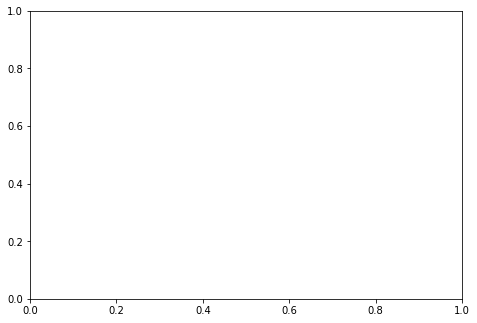

In [91]:
import seaborn as sns
# Unique category labels
color_labels = cp_df.orgcat.unique()

# List of RGB triplets
rgb_values = sns.color_palette(palette="tab10", n_colors=len(color_labels))

# Map label to hex colors
color_map = dict(zip(color_labels, rgb_values.as_hex()))
pd.DataFrame().from_dict(color_map, orient='index').style.apply(lambda x: ['background-color: {}'.format(x[0])], axis=1)
# for node in rempgraph:
#     color_map.append(graph.nodes[node]['color'])
nx.draw(rempgraph, node_color=color_map, with_labels=True)
plt.show()

In [92]:
nodes = rempgraph.nodes
nodes['REMP']

KeyError: 'REMP'

In [93]:
centralities = nx.eigenvector_centrality(graph)


NetworkXPointlessConcept: cannot compute centrality for the null graph

In [103]:
nxa.draw_networkx_nodes( G=rempgraph,
    pos=pos,
    node_size="centrality",
    node_color='entity_type',
    edge_color='community',
    node_label=True,
    cmap='accent',
    node_tooltip=['name', 'centrality', "community"]
)

KeyError: 0

In [95]:
communities = list(nx.community.label_propagation_communities(graph))
my_communities = {
 'ICEM':{'Appleyard, R.T.',
  'Balhana, A.Pilatti',
  'Beijer, G.',
  'Beld, van den, C.A.',
  'Belshaw, H.',
  'Borrie, W.D.',
  'Cidor, H.A.',
  'Dorpema, H.',
  'Fagley, R.',
  'Geyl, W.F.',
  'Glinstra Bleeker, van, R.J.P.',
  'Gottmann, J.',
  'Hack, H.',
  'Herberle, R.',
  'Heyn, H.',
  'Hyrenius, H.',
  'Kraak, J.H.',
  'Luckham, B.',
  'Lyon, A.V.',
  'MacKay, M.C.J.',
  'Mackenroth, G.',
  'Mannoni, E.',
  'Maris, A.',
  'Mast, van der, W.',
  'Mol, J.J.',
  'Nixon, J.W.',
  'Olsson, B.',
  'Orleans, L.A.',
  'Paulson, B.',
  'Peltier, R.',
  'Pressat, R.',
  'Price, C.A.',
  'Putten, v.d., A.',
  'Rees, E.',
  'Reid, I.D.A.',
  'Richardson, A.',
  'Rosenfield, H.N.',
  'Rubin, E.',
  'Schmitz, J.P.G.',
  'Sjollema, B.Ch.',
  'Starr, M.',
  'Timlin, M.F.',
  'Weinberg, A.A.W.',
  'Wentholt, R.',
  'Witcover, J.',
  'Witkamp, T.','ICEM'},
 'REMP':{'Beijer, G.',
         'Bastos de Avila, F.',
  'Bouman, P.J.',
  'Brackel, P.O.M.',
  'Brink, van den , T.',
  'Brink, van den, T',
  'Camillo de Oliveira, A.',
  'Citroen, H.A.',
  'Davis, K.',
  'Edding, F.',
  'Gadolin, de, A.',
  'Glass, D.V.',
  'Groenman, Sj.',
  'HWvanLoon Fellowship, NL regering',
  'Hofstee, E.W.',
  'Institute of International Education',
  'Ipsen, G.',
  'Isaac, J.',
  'Klompe, M.',
  'Lannes, X.',
  'Mill, van, A.N.',
  'Oudegeest, J.J.',
  'Petersen, W.',
  'REMP',
  'Rappard, W.E.',
  'Salin, E.',
  'Sauvy, A.',
  'Steigenga, W.',
  'Verkade, W.',
  'Verwey-Jonker, H.',
  'Wander, H.',
  'Zeegers, G.H.L.',
  'Hofstede, B.P.', 
  'RCE'},
'rest': {'Clemens, R.', 'Zubrzycki, J.', 'Godefroy, J.', 'Meyers, H.G.', 'Patijn, C.L.', 'Witkamp, F.Th.',
         'Brepohl, W.', 'Lehmkuhler, M.','Lewis, J.N.', 'Sauvon, E.A.','Neher, L.', 'Radspieler, T.',
         'Bentwich, N.', 'Beveridge, W.H.'}}

In [104]:
for f in graph.edges():
    for i, c in my_communities.items():
         if f[0] and f[1] in c:
            comty = graph.edges[f].get('community') or ''
            comty = ', '.join([comty,i])
            graph.edges[f].update({"community" : comty,
                                })

In [105]:
'/'.join(['a','b'])

'a/b'

In [107]:
#first reset community on graph nodes
for f in graph.nodes():
    rempgraph.nodes[f].update({"community" : ''})

for f in rempgraph.nodes():
    for i, c in my_communities.items():
        if f in c:
            comty = graph.nodes[f].get('community') or ''
            comty = '/'.join([comty,i])[1:]
            label = ''
            if comty == "rest":
                label = f
            rempgraph.nodes[f].update({"community" : comty,
                                "centrality" : centralities[f]*2,
                                "name" : f,
                                "label" : label
                               })

In [109]:
rempgraph

In [110]:


pos = nx.spring_layout(graph)

            
chart = nxa.draw_networkx(
    G=graph,
    pos=pos,
    node_size="centrality",
    node_color='entity_type',
    edge_color='community',
    cmap='accent',
    node_tooltip=['name', 'centrality', "community"],
    node_label='label'
)

chart.configure_view(width=1000, height=800, )


ValueError: G does not contain any nodes or edges.

In [63]:
import nx_altair as nxa
import altair as alt

# # Compute positions for viz.
# pos = nx.kamada_kawai_layout(graph)

# # Draw the graph using Altair
# viz = nxa.draw_networkx(graph, pos=pos)
# brush = alt.selection_interval(encodings=['x', 'y'])
# color = alt.Color('viable:N',  legend=None)




#pos = nx.spring_layout(graph)
partition = community_louvain.best_partition(graph)
pos = community_layout(graph, partition)


chart = nxa.draw_networkx(
    G=graph,
    pos=pos,
    node_size="centrality",
    node_color='color',
    edge_color='community',
    cmap='accent',
    node_tooltip=['name', 'entity_type']
)

chart.configure_view(width=800, height=400)

# Get the node layer
edges = chart.layer[0]
nodes = chart.layer[1]

# Build a brush
brush = alt.selection_interval(encodings=['x', 'y'])
color = alt.Color('community:N')

# Condition nodes based on brush
nodes = nodes.encode(
    fill=alt.condition(brush, color, alt.value('gray')),
).add_selection(
    brush
)

# Create a bar graph to show highlighted nodes.
bars = alt.Chart(nodes.data).mark_bar().encode(
    x=alt.X('count()', scale=alt.Scale(domain=(0,50))),
    y='community',
    color='entity_type',
).transform_filter(
    brush
)

alt.vconcat(edges+nodes, bars).configure_view(width=1000, height=800, )




NameError: name 'community_louvain' is not defined

In [64]:
[node for node in graph.nodes if graph.nodes.get(node).get('community')=='3']

[]

In [65]:
graph.nodes.get('Wander, H.').get('community')

AttributeError: 'NoneType' object has no attribute 'get'

In [66]:
with open('/Users/rikhoekstra/Downloads/testnxgraph.json', 'w') as tg:
    json.dump(fp=tg, obj=nx.json_graph.node_link_data(graph))

In [67]:
#nx.draw_spring(graph, with_labels=True, font_weight='bold')
pos = nx.spring_layout(graph, k=0.9)
#nx.draw_networkx_nodes(graph, pos)
#nx.draw_spectral(graph, with_labels=True, font_weight='bold')
pos

{}

In [68]:
import sys
!{sys.executable} -m pip install python-louvain

You should consider upgrading via the 'pip install --upgrade pip' command.


In [69]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

def test():
    #to install networkx 2.0 compatible version of python-louvain use:
     
    from community import community_louvain


    partition = community_louvain.best_partition(graph)
    pos = community_layout(graph, partition)

    nx.draw(graph, pos, node_color=list(partition.values())); plt.show()
    return



In [70]:
from community import community_louvain
partition = community_louvain.best_partition(graph)
#pos = community_layout(g, partition)
partition
for (ni, nj) in graph.edges():
     ci = partition[ni]
     cj = partition[nj]

In [71]:
communities

NameError: name 'communities' is not defined

In [72]:
g = nx.karate_club_graph()
partition = community_louvain.best_partition(g)
partition
# pos = community_layout(g, partition)

# nx.draw(g, pos, node_color=list(partition.values())); plt.show()

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 3,
 5: 3,
 6: 3,
 7: 0,
 8: 2,
 9: 0,
 10: 3,
 11: 0,
 12: 0,
 13: 0,
 14: 2,
 15: 2,
 16: 3,
 17: 0,
 18: 2,
 19: 0,
 20: 2,
 21: 0,
 22: 2,
 23: 1,
 24: 1,
 25: 1,
 26: 2,
 27: 1,
 28: 1,
 29: 2,
 30: 2,
 31: 1,
 32: 2,
 33: 2}

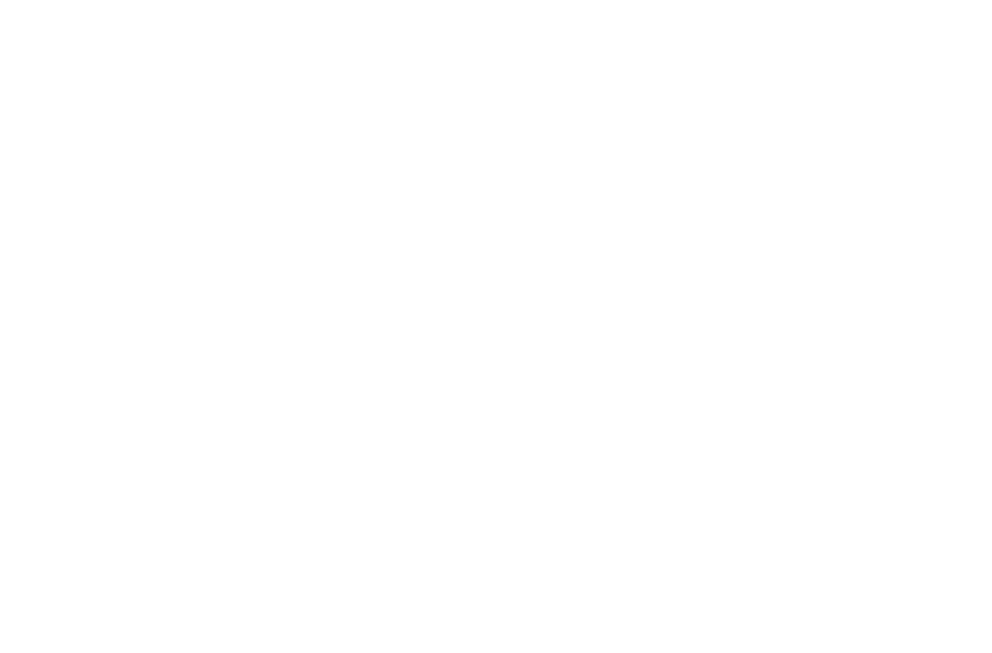

In [82]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

nx.draw_networkx_nodes(graph, pos)
nx.draw_spring(graph, with_labels=False, font_weight='bold')


In [83]:
    
nodes_of_largest_component  = max(nx.connected_components(graph), key = len)
largest_component = graph.subgraph(nodes_of_largest_component)
color_map = []
for node in largest_component:
    color_map.append(graph.nodes[node]['color'])

nx.draw_spring(largest_component, node_color=color_map, with_labels=True)
#nx.draw(largest_component, node_color=color_map, with_labels=True)

IndentationError: expected an indented block (<ipython-input-83-20b82f1bb78e>, line 6)

In [84]:
from scripts.network_analysis import generate_graph, add_entities, add_record_links

viftiessgraph = generate_graph()

periods = [
    {'start': 1950, 'end': 1955}, 
#     {'start': 1960, 'end': 1969},
#     {'start': 1970, 'end': 1979},
#     {'start': 1980, 'end': 1989},
]

period = periods[0]
for record in relationship_records:
    record['year'] = int(record['year'])
for ri, record in enumerate(sorted(relationship_records, key = lambda x: x['year'])):
    record['year'] = int(record['year'])
    if record['year'] < period['start'] or record['year'] > period['end']:
        continue
    print(record['year'])
    entities = extract_record_entities(record)
    for entity in entities:
        if entity['entity_type'] == 'person':
            entity['entity_type'] = get_entity_category(entity)
    named_entities = [entity for entity in entities if 'entity_name' in entity]
    print([entity['entity_name'] for entity in named_entities])
    add_entities(viftiessgraph, named_entities)
    add_record_links(viftiessgraph, named_entities)
    if ri == 100:
        break

viftiessgraph.number_of_nodes()

1951


NameError: name 'entity_category' is not defined

In [85]:
viftiessgraph.nodes

NodeView(())

In [86]:
fiftiescentralities = nx.eigenvector_centrality(viftiessgraph)
fiftiescentralities

NetworkXPointlessConcept: cannot compute centrality for the null graph

In [87]:
vpos = nx.spring_layout(viftiessgraph)
nxa.draw_networkx_nodes( G=viftiessgraph,
    pos=vpos,
#     node_size="centrality",
    node_color='entity_type',
    node_label=True,
    cmap='accent',
    node_tooltip=['name', 'centrality', "community"]
)

ValueError: entity_type encoding field is specified without a type; the type cannot be inferred because it does not match any column in the data.

alt.Chart(...)

In [88]:
chart = nxa.draw_networkx(
    G=viftiessgraph,
    pos=pos,
    #node_size="centrality",
    node_color='entity_type',
#     edge_color='community',
    cmap='accent',
    node_tooltip=['name'],
#     node_label='label'
)

chart.configure_view(width=1000, height=800, )

ValueError: G does not contain any nodes or edges.

In [89]:
nxa.draw_networkx_edges

<function nx_altair.draw_altair.draw_networkx_edges(G=None, pos=None, chart=None, layer=None, edgelist=None, width=1, alpha=1.0, edge_color='black', edge_cmap=None, tooltip=None, legend=False, **kwargs)>

In [90]:
nxa.draw_networkx(G=viftiessgraph, font_color="green")

ValueError: G does not contain any nodes or edges.

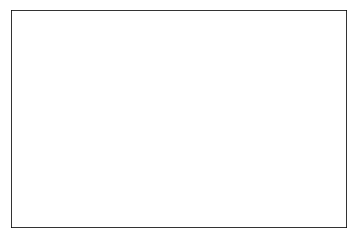

In [91]:
nx.draw_networkx(viftiessgraph)